In [ ]:
! pip install evaluate transformers==4.52.1 rouge-score nltk
! pip install -U datasets

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/Transformers/Project_T5')

In [ ]:
from datasets import load_dataset
from evaluate import load

raw_datasets = load_dataset("xsum")
metric = load("rouge")

In [ ]:
raw_datasets["train"] = raw_datasets["train"].shuffle(seed=42).select(range(20000))
raw_datasets["validation"] = raw_datasets["validation"].shuffle(seed=42).select(range(2000))
raw_datasets["test"] = raw_datasets["test"].shuffle(seed=42).select(range(2000))

In [ ]:
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['document', 'summary', 'id'],
        num_rows: 20000
    })
    validation: Dataset({
        features: ['document', 'summary', 'id'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['document', 'summary', 'id'],
        num_rows: 2000
    })
})

In [ ]:
from transformers import AutoTokenizer

model_checkpoint = "google/t5-v1_1-small"
fp16_problem = False

if model_checkpoint.startswith("google/t5-v1_1"):
  fp16_problem = True
  print("This model has a problem with fp16, we will apply a fix later on.")

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

This model has a problem with fp16, we will apply a fix later on.


tokenizer_config.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/537 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [ ]:
max_input_length = 1024
max_target_length = 128
prefix = "summarize: "

def preprocess_function(examples):
    inputs = [prefix + doc for doc in examples["document"]]
    model_inputs = tokenizer(inputs, max_length=max_input_length, truncation=True)

    # Setup the tokenizer for targets
    labels = tokenizer(text_target=examples["summary"], max_length=max_target_length, truncation=True)

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

tokenized_datasets = raw_datasets.map(preprocess_function, batched=True)

Map:   0%|          | 0/20000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [ ]:
import nltk
import numpy as np
import matplotlib.pyplot as plt
from transformers import TrainerCallback
nltk.download('punkt_tab')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)

    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Rouge expects a newline after each sentence
    decoded_preds = ["\n".join(nltk.sent_tokenize(pred.strip())) for pred in decoded_preds]
    decoded_labels = ["\n".join(nltk.sent_tokenize(label.strip())) for label in decoded_labels]

    result = metric.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True, use_aggregator=True)
    result = {key: value * 100 for key, value in result.items()}

    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in predictions]
    result["gen_len"] = np.mean(prediction_lens)

    return {k: round(v, 4) for k, v in result.items()}


class PlotLossAccuracyCallback(TrainerCallback):
    def __init__(self):
        self.train_loss = []
        self.eval_loss = []
        self.eval_acc = []

    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs is None:
            return

        print(f"[LOG] Step {state.global_step}: {logs}")

        if "loss" in logs:
            self.train_loss.append((state.global_step, logs["loss"]))
        if "eval_loss" in logs:
            self.eval_loss.append((state.global_step, logs["eval_loss"]))
        if "eval_accuracy" in logs:
            self.eval_acc.append((state.global_step, logs["eval_accuracy"]))

    def plot(self):
      steps_train, loss_train = zip(*self.train_loss) if self.train_loss else ([], [])
      steps_eval, loss_eval = zip(*self.eval_loss) if self.eval_loss else ([], [])
      steps_acc, acc_eval = zip(*self.eval_acc) if self.eval_acc else ([], [])

      plt.figure(figsize=(12, 5))

      if loss_train or loss_eval:
          plt.subplot(1, 2, 1)
          if loss_train:
              plt.plot(steps_train, loss_train, label="Train Loss")
          if loss_eval:
              plt.plot(steps_eval, loss_eval, label="Eval Loss")
          plt.xlabel("Step")
          plt.ylabel("Loss")
          plt.title("Training and Eval Loss")
          plt.legend()

      if acc_eval:
          plt.subplot(1, 2, 2)
          plt.plot(steps_acc, acc_eval, label="Eval Accuracy", color="green")
          plt.xlabel("Step")
          plt.ylabel("Accuracy")
          plt.title("Validation Accuracy")
          plt.legend()

    plt.tight_layout()
    plt.savefig("loss_accuracy_plot.png")
    plt.show()


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


<Figure size 640x480 with 0 Axes>

# **Problem with fp16 fix**

In [ ]:
import torch
from transformers.models.t5.modeling_t5 import T5LayerFF

def _forward(self, hidden_states):
        forwarded_states = self.layer_norm(hidden_states)
        forwarded_states = self.DenseReluDense(forwarded_states)
        hidden_states = hidden_states + self.dropout(forwarded_states)
        return hidden_states

def safe_t5_ff_forward(self, hidden_states):
    # many t5/mt5 models are trained in bfloat16 and don't do well under mixed precision (fp16).
    # It appears that it's enough to disable autocast for this FF layer to avoid inf/nan
    # problems for the whole model
    if torch.is_autocast_enabled():
        with torch.cuda.amp.autocast(enabled=False):
            return self._forward(hidden_states)
    else:
        return self._forward(hidden_states)

if fp16_problem:
  print(f"Patching T5LayerFF.forward for {model_checkpoint} to disable AMP in FF layer")
  T5LayerFF._forward = _forward
  T5LayerFF.forward = safe_t5_ff_forward

Patching T5LayerFF.forward for google/t5-v1_1-small to disable AMP in FF layer


# **Training loop**

pytorch_model.bin:   0%|          | 0.00/308M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/308M [00:00<?, ?B/s]

/tmp/ipython-input-14-554596481.py:31: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(
Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum,Gen Len
1,3.683600,2.778972,26.194400,6.433300,20.395400,20.426000,18.976000
2,3.465100,2.703583,26.588500,6.716400,20.692200,20.727000,19.315000


[LOG] Step 150: {'loss': 6.3571, 'grad_norm': 32.189414978027344, 'learning_rate': 9.702e-05, 'epoch': 0.06}
[LOG] Step 300: {'loss': 4.8038, 'grad_norm': 12.057365417480469, 'learning_rate': 9.402000000000001e-05, 'epoch': 0.12}
[LOG] Step 450: {'loss': 4.5299, 'grad_norm': 7.97743034362793, 'learning_rate': 9.102e-05, 'epoch': 0.18}
[LOG] Step 600: {'loss': 4.3233, 'grad_norm': 5.1252593994140625, 'learning_rate': 8.802e-05, 'epoch': 0.24}
[LOG] Step 750: {'loss': 4.1546, 'grad_norm': 7.032927513122559, 'learning_rate': 8.502e-05, 'epoch': 0.3}
[LOG] Step 900: {'loss': 4.1041, 'grad_norm': 13.316222190856934, 'learning_rate': 8.202e-05, 'epoch': 0.36}
[LOG] Step 1050: {'loss': 4.0, 'grad_norm': 4.81780481338501, 'learning_rate': 7.902e-05, 'epoch': 0.42}
[LOG] Step 1200: {'loss': 3.959, 'grad_norm': 4.928497791290283, 'learning_rate': 7.602000000000001e-05, 'epoch': 0.48}
[LOG] Step 1350: {'loss': 3.8993, 'grad_norm': 6.452826499938965, 'learning_rate': 7.302e-05, 'epoch': 0.54}
[LOG

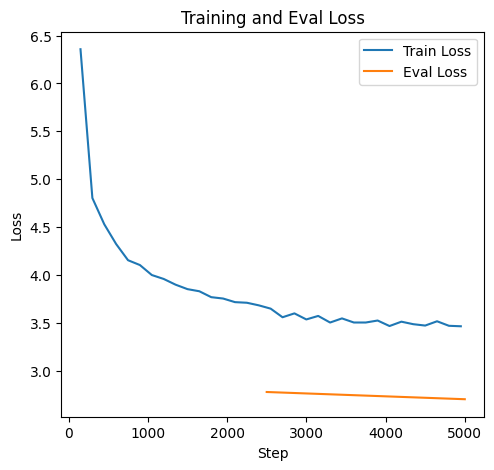

In [ ]:
from T5_to_GQA import convert_t5_to_gqa
from transformers import AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq, Seq2SeqTrainingArguments, Seq2SeqTrainer


kv_list = [6]
for kv_heads in kv_list:
  model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)
  convert_t5_to_gqa(model.decoder, kv_heads=kv_heads, inplace=True)

  batch_size = 8
  args = Seq2SeqTrainingArguments(
      output_dir=f"/content/drive/MyDrive/technion/Trasformers/Project_T5/fine_tune_Xsum_{kv_heads}",
      eval_strategy = "epoch",
      save_strategy="epoch",
      learning_rate=1e-4,
      per_device_train_batch_size=batch_size,
      per_device_eval_batch_size=batch_size,
      weight_decay=0.01,
      save_total_limit=1,
      num_train_epochs=2,
      logging_dir="/content/drive/MyDrive/technion/Trasformers/Project/logs",
      logging_steps=150,
      predict_with_generate=True,
      report_to="none"
  )

  data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

  plot_callback = PlotLossAccuracyCallback()

  trainer = Seq2SeqTrainer(
      model,
      args,
      train_dataset=tokenized_datasets["train"],
      eval_dataset=tokenized_datasets["validation"],
      data_collator=data_collator,
      tokenizer=tokenizer,
      compute_metrics=compute_metrics,
      callbacks=[plot_callback]
  )

  trainer.train()
  plot_callback.plot()

In [ ]:
test_results = trainer.predict(tokenized_datasets["test"].select(range(500)))

# Print ROUGE-1 (and optionally others)
print("Test set ROUGE scores:")
print(f"ROUGE-1: {test_results.metrics['test_rouge1']:.2f}")

Test set ROUGE scores:
ROUGE-1: 25.70
